## Young People's Dataset Survey

### Initial Data Cleaning

Reads the responses.csv and splits it into X and target variable. The rows with "blanks" in target variables are dropped as it might not be a good idea to impute the target variable values.

After this, the data is concatenated again and goes through autocleaning which does data imputation of remaining missing values of feature set examples.

It is interesting to note that while Autoclean takes mean for continuous values like 'Height' to calculate the missing values, it uses mode for other categorical values like 'Entertainment spending'. This is what I was hoping to do so it fits perfectly.

Autoclean also makes sure all columns have numerical values. 

The data is split again into features and target variable examples.

In [10]:
from datacleaner import autoclean
import pandas as pd
from sklearn.utils import shuffle

data = pd.read_csv("responses.csv", sep=',')
data = shuffle(data)
data_X = data.drop('Empathy', axis=1)
data_Y = data['Empathy']
for i,nullbool in enumerate(data_Y.isnull()):
    if nullbool==True:
        data_Y = data_Y.drop(data.index[i])
        data_X = data_X.drop(data.index[i])
data_Y = data_Y.reset_index(drop=True)
data_X = data_X.reset_index(drop=True)
data = pd.concat([data_X, data_Y], axis=1)
autoclean(data, drop_nans=False, copy=False, ignore_update_check=False)
train_data = data[:-150]
test_data = data[-150:]
test_data_X = test_data.drop('Empathy', axis=1)
test_data_Y = test_data['Empathy']
data = train_data
data_Y = data['Empathy']
data_X = data.drop('Empathy', axis=1)




### One-hot encoding (Skip this)

We perform one-hot encoding to use it for classification models. Also, we do not do one-hot encoding for continuous features like Height, Weight etc. 
#### This isn't needed as the feature values are weighted and express various degrees.  (or they are continuous)

In [47]:
# import pandas as pd
# from dummyPy import OneHotEncoder

# # Making all columns have numerical data - almost done - not required as autoclean solves problem

# # unique_vals=[]
# # for col in cols:
# #     unique_vals.append(data[col].unique())

# # for index, row in data.iterrows():
# #     for col in cols:
# #         print(col)
# #         if row[col] in unique_vals[col] and row[col]!="" and row[col].isnull()!= True:
# #             row[col]= unique_vals[col].index(row[col])

# # One-hot encoding - Not required as feature values are expression of various degrees and are weighted.

# data_X_O = data_X.drop('Height', axis=1)
# data_X_O = data_X_O.drop('Weight', axis=1)
# data_X_O = data_X_O.drop('Age', axis=1)


# cols = list(data_X_O)

# encoder = OneHotEncoder(cols)
# encoder.fit(data_X_O)
# data_X_O = encoder.transform(data_X_O)
# Height = data_X['Height']
# Weight = data_X['Weight']
# Age = data_X['Age']
# data_X = pd.concat([data_X_O, Height, Weight, Age], axis=1)
# print(data_X)

### Normalization of Data

We perform feature normalization for all features.

In [2]:
from sklearn import preprocessing
df_X = pd.DataFrame()
cols = list(data_X)
for col in cols:
    column = data_X[[col]].values.astype(float)
    # Create a minimum and maximum processor object
    min_max_scaler = preprocessing.MinMaxScaler()
    
    # Create an object to transform the data to fit minmax processor
    column_scaled = min_max_scaler.fit_transform(column)
    # Run the normalizer on the dataframe
    df_X = pd.concat([df_X, pd.DataFrame(column_scaled, columns=data_X[[col]].columns)], axis=1)
data_X = df_X

## Analyzing the target variable

We see from a seaborn plot of the distribution of target variable observation that the there is a severe representation problem withing the classes. Classes are increasingly represented as we move from 1 to 5.

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.distplot(data_Y)
plt.show()

c:\users\administrator\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


<Figure size 640x480 with 1 Axes>

We use SMOTE to balance our imbalanced dataset by 'creating synthetic' new features for the under-represented class.

In [18]:
from imblearn.over_sampling import SMOTE
from imblearn.datasets import make_imbalance

# X_resampled, y_resampled = make_imbalance(X,y, ratio = 0.2, min_c_ = "Senate", random_state = 249)

smote = SMOTE(kind = "borderline1", k_neighbors  = 10)
data_X, data_Y = smote.fit_sample(data_X, data_Y)


Let's plot target variable distribution again.

c:\users\administrator\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


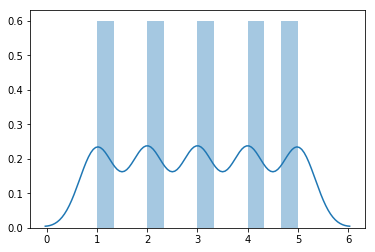

In [21]:
sns.distplot(data_Y)
plt.show()

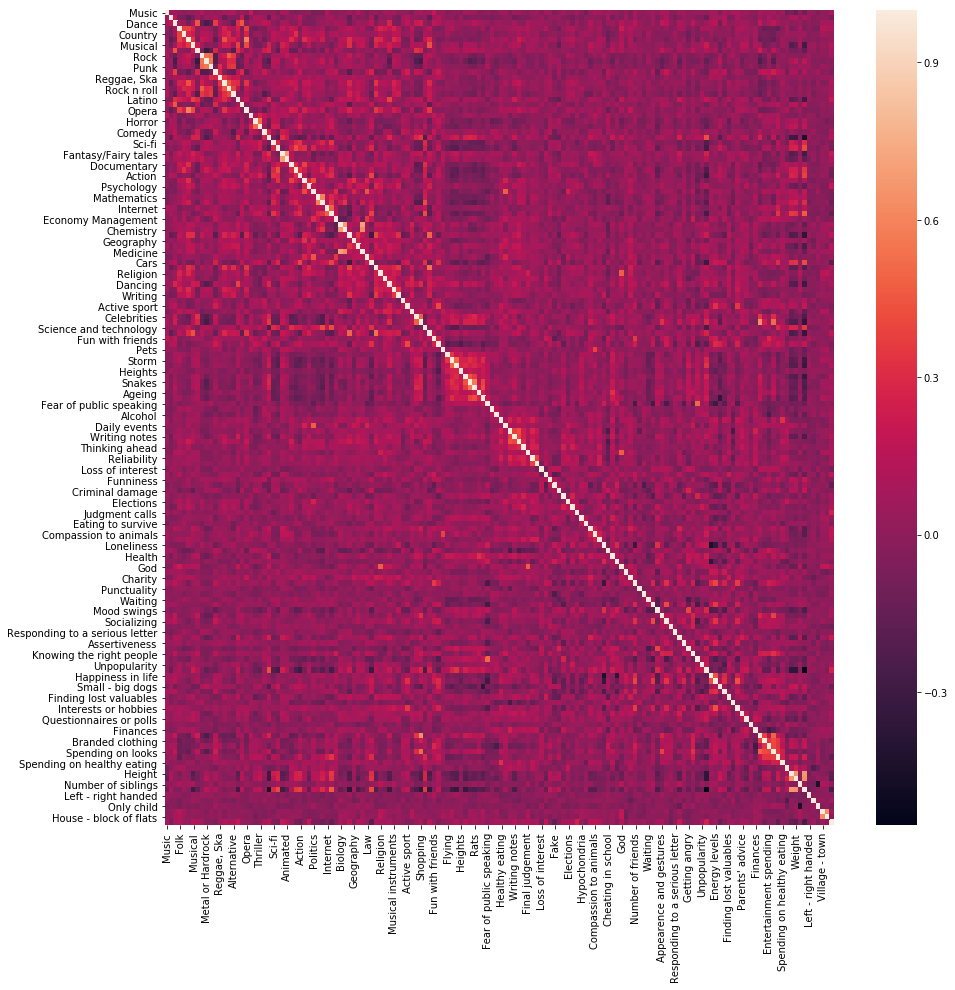

In [151]:
corr_mat = data.corr()
plt.subplots(figsize=(15,15))
sns.heatmap(corr_mat)
plt.show()


In [152]:
target_corr = corr_mat['Empathy'].sort_values(ascending=False)
possibly_irrelevant_features = [feature for feature,elem in target_corr.items() if elem<0.01 if elem >-0.01]
print(possibly_irrelevant_features)

['Number of siblings', 'Cheating in school', 'Fear of public speaking', 'New environment', 'Assertiveness', 'Movies', 'Public speaking', 'Internet usage', 'Spending on healthy eating', 'Socializing', 'Punk', 'Spending on looks', 'Knowing the right people']


In [153]:
cols = list(data_X)
for col in cols:
    target_corr = corr_mat[col].sort_values(ascending=False)
    feature_most_correlated_with_own = [feature for feature,elem in target_corr.items() if elem>0.7 or elem <-0.75]
    if len(feature_most_correlated_with_own)>1:
        print("High Correlated features for ", col)
        print(feature_most_correlated_with_own[1:])

High Correlated features for  Biology
['Medicine']
High Correlated features for  Medicine
['Biology']


## Principal Componenet Analysis

PCA is fundamentally a dimensionality reduction algorithm, but it can also be useful as a tool for visualization, for noise filtering, for feature extraction and engineering. 

The main goal of a PCA analysis is to identify patterns in data; PCA aims to detect the correlation between variables. If a strong correlation between variables exists, the attempt to reduce the dimensionality only makes sense. In a nutshell, this is what PCA is all about: Finding the directions of maximum variance in high-dimensional data and project it onto a smaller dimensional subspace while retaining most of the information.

In [166]:
from sklearn.decomposition import PCA
pca = PCA(0.95)
pca.fit(data_X)
print(pca.explained_variance_)
pca.n_components_
data_X_new = pca.transform(data_X)
test_data_X_new = pca.transform(test_data_X)
data_new = pd.concat([pd.DataFrame(data_X_new), data_Y], axis=1)

[1.02718804 0.77826284 0.65284816 0.44275342 0.39339223 0.36086209
 0.32520031 0.27866909 0.24550531 0.23176873 0.23058484 0.22228992
 0.21038864 0.20232031 0.19623663 0.19185969 0.18053074 0.17656584
 0.16758709 0.16538725 0.16323609 0.15410409 0.1485406  0.14593195
 0.14234077 0.14002337 0.13463997 0.13406614 0.13126975 0.12470273
 0.12125839 0.11941439 0.11668533 0.11203468 0.11035497 0.10977921
 0.10800978 0.10653615 0.10257944 0.10117043 0.09839505 0.0977975
 0.09585696 0.09469972 0.09330292 0.09235083 0.08921696 0.08823881
 0.08741775 0.08690691 0.08389308 0.08292168 0.08173283 0.07986942
 0.07872136 0.07789101 0.07640502 0.07429046 0.07377817 0.07288315
 0.07197479 0.07047357 0.06967417 0.06908399 0.06856979 0.06638464
 0.06516489 0.06448723 0.06321308 0.06235484 0.0617784  0.06091416
 0.05999871 0.05950244 0.05878803 0.05692737 0.05595969 0.05545343
 0.05444657 0.05390716 0.05332631 0.05268526 0.05146942 0.05090845
 0.04938159 0.04889624 0.04864134 0.04811988 0.04688385 0.04653

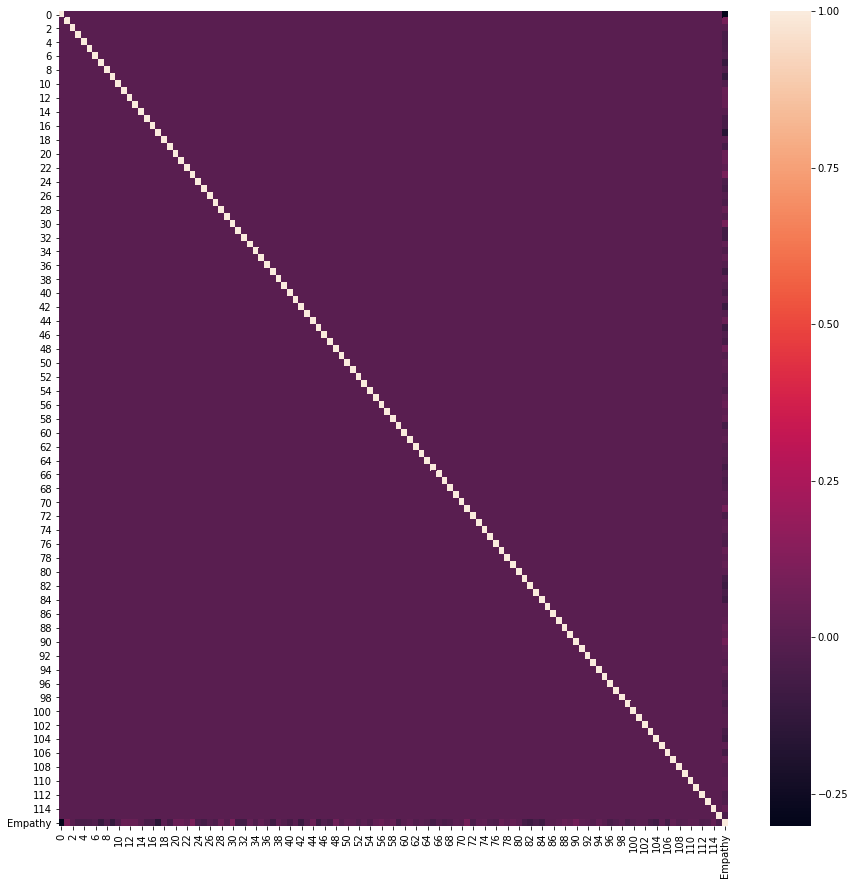

[87, 105, 57, 78, 73, 53, 18, 80, 92, 111, 69, 98, 63, 41, 95, 86, 70, 60, 2, 102, 14, 85, 101]


In [167]:
corr_mat = data_new.corr()
plt.subplots(figsize=(15,15))
sns.heatmap(corr_mat)
plt.show()
target_corr = corr_mat['Empathy'].sort_values(ascending=False)
possibly_irrelevant_features = [feature for feature,elem in target_corr.items() if elem<0.01 if elem >-0.01]
print(possibly_irrelevant_features)

In [174]:
cols = list(data_X_new)
for feature,elem in corr_mat.items():
    target_corr = corr_mat[feature].sort_values(ascending=False)
    feature_most_correlated_with_own = [feature for feature,elem in target_corr.items() if elem>0.7 or elem <-0.7]
    if len(feature_most_correlated_with_own)>1:
        print("High Correlated features for ", feature)
        print(feature_most_correlated_with_own[1:])

## Model Evaluation

The below funcion calculates accuracy scores, F-score, Precision and Recall after employing K-Fold Cross Validation. 

In [14]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
import numpy as np

def get_cv_metrics(text_clf, train_data, train_class, k_split):
    accuracy_scores = cross_val_score(text_clf,  # steps to convert raw messages      into models
                                      train_data,  # training data
                                      train_class,  # training labels
                                      cv=k_split,  # split data randomly into 10 parts: 9 for training, 1 for scoring
                                      scoring='accuracy',  # which scoring metric?
                                      n_jobs=-1,  # -1 = use all cores = faster
                                      )
    cv_predicted = cross_val_predict(text_clf,
                                     train_data,
                                     train_class,
                                     cv=k_split)

    return np.mean(accuracy_scores), classification_report(train_class, cv_predicted)

## Learning Models

### SGD

#### Tuning

Let us tune the hyperparameters using Grid Search cross-validation.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model

def tune_SGD():
    clf = linear_model.SGDClassifier()
    parameters = {'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron',],
                  'penalty': ['l2','l1','elasticnet'],
                  'max_iter': [1000000,10000, 100, 10],
                  'tol': [1e-2,1e-3,1e-4],
                  'alpha': [1e-3, 1e-4,1e-2]}
    gs_clf = GridSearchCV(clf, parameters, n_jobs=-1)
    gs_clf = gs_clf.fit(data_X, data_Y)
    print(gs_clf.best_score_)
    for param_name in sorted(parameters.keys()):
        print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))
tune_SGD()

#### Training

We will now train the model using parameters from above tuning that gave best score.

In [22]:
from sklearn.externals import joblib
from sklearn import linear_model
from sklearn.metrics import accuracy_score

def train_SGD():
    
    '''TRAINING'''

    clf = linear_model.SGDClassifier(loss='log', penalty='l2',alpha=1e-3, random_state=16,max_iter=10000, tol=0.01, shuffle=True).fit(data_X,data_Y)    
    joblib.dump(clf, 'SGD_model.pkl')

    
    """PERFORMANCE EVALUATION"""
    accuracy, clf_report = get_cv_metrics(clf, data_X, data_Y, k_split=10)
    print("Accuracy: ", accuracy)
    print(clf_report)
    return clf
    
model = train_SGD()  
#Accuracy:  0.383326379637346
pred_Y = model.predict(test_data_X)
print("Test Accuracy: ", accuracy_score(test_data_Y, pred_Y))
#Accuracy:  0.02666666666666667

Accuracy:  0.3876209677419355
             precision    recall  f1-score   support

        1.0       0.62      0.65      0.63       318
        2.0       0.43      0.39      0.41       318
        3.0       0.31      0.25      0.27       318
        4.0       0.42      0.07      0.12       318
        5.0       0.28      0.58      0.38       318

avg / total       0.41      0.39      0.36      1590

Test Accuracy:  0.43333333333333335


## Naive Bayes

### Multinomial Naive Bayes

#### Tuning

Let us tune the hyperparameters using Grid Search cross-validation.

In [64]:
from sklearn.naive_bayes import MultinomialNB

def tune_MultinomialNB():
    clf = MultinomialNB()
    parameters = {'alpha': np.arange(0.0, 2.0, 0.1), 'fit_prior':[True, False], 'class_prior':[None]}
    gs_clf = GridSearchCV(clf, parameters, n_jobs=-1)
    gs_clf = gs_clf.fit(data_X, data_Y)
    print(gs_clf.best_score_)
    for param_name in sorted(parameters.keys()):
        print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))
tune_MultinomialNB()

NameError: name 'GridSearchCV' is not defined

#### Training

We can now train the Multinomial NB using the hyperparameters from GridSearch's best results. 

In [23]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

def train_MultinomialNB():
    '''TRAINING'''

    clf = MultinomialNB(alpha=0.0, fit_prior=True, class_prior=None).fit(data_X,data_Y)
    
    joblib.dump(clf, 'Multinomial_nb_model.pkl')

    """PERFORMANCE EVALUATION"""
    accuracy, clf_report = get_cv_metrics(clf, data_X, data_Y, k_split=10)
    print("Accuracy: ", accuracy)
    print(clf_report)
    return clf

model = train_MultinomialNB()
pred_Y = model.predict(test_data_X)
print("Test Accuracy: ", accuracy_score(test_data_Y, pred_Y))
#Accuracy:  0.40399650186349884

c:\users\administrator\appdata\local\programs\python\python36\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


Accuracy:  0.4885080645161291
             precision    recall  f1-score   support

        1.0       0.77      0.80      0.78       318
        2.0       0.50      0.69      0.58       318
        3.0       0.44      0.24      0.31       318
        4.0       0.28      0.12      0.17       318
        5.0       0.37      0.59      0.45       318

avg / total       0.47      0.49      0.46      1590

Test Accuracy:  0.4066666666666667


c:\users\administrator\appdata\local\programs\python\python36\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
c:\users\administrator\appdata\local\programs\python\python36\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
c:\users\administrator\appdata\local\programs\python\python36\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
c:\users\administrator\appdata\local\programs\python\python36\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
c:\users\administrator\appdata\local\programs\python\python36\lib\site-packa

### Bernoulli Navie Bayes
#### Tuning

Let us tune the hyperparameter of BernoulliNB using Grid Search cross-validation.

In [32]:
from sklearn.naive_bayes import BernoulliNB

def tune_BernoulliNB():
    clf = BernoulliNB()
    parameters = {'alpha': np.arange(0.0, 2.0, 0.1), 'fit_prior':[True, False], 'class_prior':[None]}
    gs_clf = GridSearchCV(clf, parameters, n_jobs=-1)
    gs_clf = gs_clf.fit(data_X, data_Y)
    print(gs_clf.best_score_)
    for param_name in sorted(parameters.keys()):
        print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))
tune_BernoulliNB()

NameError: name 'GridSearchCV' is not defined

#### Training

We can now train the Bernoulli NB using the hyperparameters from GridSearch's best results. 

In [25]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score

def train_BernoulliNB():
    '''TRAINING'''

    clf = BernoulliNB(alpha=1.9, fit_prior=True, class_prior=None).fit(data_X, data_Y)
    joblib.dump(clf, 'Bernoulli_nb_model.pkl')

    """PERFORMANCE EVALUATION"""
    accuracy, clf_report = get_cv_metrics(clf, data_X, data_Y, k_split=10)
    print("Accuracy: ", accuracy)
    print(clf_report)
    return clf

model = train_BernoulliNB()
pred_Y = model.predict(test_data_X)
print("Test Accuracy: ", accuracy_score(test_data_Y, pred_Y))
# Accuracy:  0.4059908968029403

Accuracy:  0.3663306451612903
             precision    recall  f1-score   support

        1.0       0.43      0.64      0.51       318
        2.0       0.33      0.40      0.36       318
        3.0       0.33      0.22      0.27       318
        4.0       0.22      0.08      0.12       318
        5.0       0.38      0.49      0.43       318

avg / total       0.34      0.37      0.34      1590

Test Accuracy:  0.31333333333333335


### Random forest
#### Tuning

Let us tune the hyperparameters of Random Forest using Grid Search cross-validation.

In [208]:
from sklearn.ensemble import RandomForestClassifier
def tune_RF():
    clf = RandomForestClassifier()
    parameters = {'n_estimators': np.arange(50, 800, 50), 'max_depth':np.arange(50, 500, 50)}
    gs_clf = GridSearchCV(clf, parameters, n_jobs=7)
    gs_clf = gs_clf.fit(data_X, data_Y)
    print(gs_clf.best_score_)
    for param_name in sorted(parameters.keys()):
        print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))
tune_RF()

0.46368159203980097
max_depth: 50
n_estimators: 650


#### Training

We can now train the Random Forest Classifer using the hyperparameters from GridSearch's best results. 

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


def train_RF():
    '''TRAINING'''
    clf = RandomForestClassifier(n_estimators = 650, max_depth=50, random_state=16, n_jobs = -1).fit(data_X,data_Y)
    joblib.dump(clf, 'RF_model.pkl')
    """PERFORMANCE EVALUATION"""
    accuracy, clf_report = get_cv_metrics(clf, data_X, data_Y, k_split=10)
    print("Accuracy: ", accuracy)
    print(clf_report)
    return clf

model = train_RF()
pred_Y = model.predict(test_data_X)
print("Test Accuracy: ", accuracy_score(test_data_Y, pred_Y))
#Accuracy:  0.38

Accuracy:  0.7706854838709678
             precision    recall  f1-score   support

        1.0       1.00      0.94      0.97       318
        2.0       0.93      0.94      0.94       318
        3.0       0.83      0.72      0.77       318
        4.0       0.61      0.52      0.56       318
        5.0       0.55      0.73      0.63       318

avg / total       0.78      0.77      0.77      1590

Test Accuracy:  0.44


### ExtraTree Classifier
#### Tuning

Let us tune the hyperparameters of Extra Tree Classifier using Grid Search cross-validation.

In [57]:
from sklearn.ensemble import ExtraTreesClassifier
def tune_ET():
    clf = ExtraTreesClassifier()
    parameters = {'n_estimators': np.arange(50, 800, 50), 'max_depth':np.arange(50, 500, 50)}
    gs_clf = GridSearchCV(clf, parameters, n_jobs=7)
    gs_clf = gs_clf.fit(data_X, data_Y)
    print(gs_clf.best_score_)
    for param_name in sorted(parameters.keys()):
        print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))
tune_ET()

NameError: name 'GridSearchCV' is not defined

#### Training

We can now train the Extra Tree Classifier using the hyperparameters from GridSearch's best results. 

In [27]:
from sklearn.ensemble import ExtraTreesClassifier
def train_ET():
    '''TRAINING'''
    clf = ExtraTreesClassifier(n_estimators = 650, max_depth=450, random_state=16, n_jobs = -1)
#     joblib.dump(clf, 'ET_model.pkl')

    """PERFORMANCE EVALUATION"""
    accuracy, clf_report = get_cv_metrics(clf, data_X, data_Y, k_split=10)
    print("Accuracy: ", accuracy)
    print(clf_report)
train_ET()
# Accuracy:  0.4407091787851031

Accuracy:  0.8026814516129033
             precision    recall  f1-score   support

        1.0       1.00      0.95      0.97       318
        2.0       0.97      0.96      0.96       318
        3.0       0.85      0.78      0.81       318
        4.0       0.66      0.59      0.62       318
        5.0       0.59      0.72      0.65       318

avg / total       0.81      0.80      0.80      1590



### SVC
#### Tuning

Let us tune the hyperparameters of Support Vector Classifier using Grid Search cross-validation.

###### Note: Since, there are lots of hyper parameters for SVC. We tune each kernel separately. Some of the hyperparameters are kernel specific like degree (only for poly) and coef0 (only for poly and sigmoid). We tune these parameters separately for each of those kernels, in the interest of saving time. 

In [32]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import numpy as np
def tune_SVC():
    clf = SVC()
#     'rbf','poly','sigmoid'
# 'degree':np.arange(2, 5, 1),
# 'coef0':np.arange(0.0, 1.0, 0.1),
    parameters = {'C': np.arange(0.1, 5, 0.5), 'kernel':['poly'], 'degree':np.arange(2, 5, 1), 'coef0':np.arange(0.0, 1.0, 0.1), 'gamma': np.arange(0, 1.0, 0.1),'tol': [1e-1,1e-2,1e-3,1e-4]}
    gs_clf = GridSearchCV(clf, parameters, n_jobs=-1)
    gs_clf = gs_clf.fit(data_X, data_Y)
    print(gs_clf.best_score_)
    for param_name in sorted(parameters.keys()):
        print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))
tune_SVC()

0.39303482587064675
C: 5
coef0: 0.8
degree: 4
gamma: 0.30000000000000004
kernel: 'poly'
tol: 0.1


#### Training

We can now train the Support Vector Classifier using the hyperparameters from GridSearch's best results. 

In [24]:
from sklearn.svm import SVC
from sklearn.externals import joblib

def train_SVM():
    '''TRAINING'''
    clf = SVC(C = 2.0, kernel='rbf', gamma = 0.1, tol = 1e-2)
    joblib.dump(clf, 'SVC_model.pkl')

    """PERFORMANCE EVALUATION"""
    accuracy, clf_report = get_cv_metrics(clf, data_X, data_Y, k_split=10)
    print("Accuracy: ", accuracy)
    print(clf_report)
train_SVM()
# Accuracy:  0.4410311180968328

Accuracy:  0.8078678678678679
             precision    recall  f1-score   support

        1.0       1.00      1.00      1.00       369
        2.0       0.97      0.99      0.98       369
        3.0       0.81      0.78      0.79       369
        4.0       0.63      0.57      0.60       369
        5.0       0.63      0.70      0.66       369

avg / total       0.81      0.81      0.81      1845



### Logistic Regression
#### Tuning

Let us tune the hyperparameters of Logistic Regression Classifier using Grid Search cross-validation.

###### Note: Since, there are lots of hyper parameters for LR. We tune each solver separately. Some of the hyperparameters are kernel specific like penalty (only l2 for 'newton-cg', 'lbfgs' and 'sag'), dual (only with l2 for liblinear), max_iter, multi_class etc. We tune these parameters separately for each of those solvers and parameters, in the interest of saving time. 

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import numpy as np

# 0.4228855721393035
# C: 0.1
# dual: True
# fit_intercept: True
# intercept_scaling: 1.7999999999999998
# n_jobs: -1
# penalty: 'l2'
# solver: 'liblinear'
# tol: 0.1

# 0.42686567164179107
# C: 3.6
# class_weight: None
# fit_intercept: False
# intercept_scaling: 1.9999999999999998
# multi_class: 'ovr'
# n_jobs: -1
# penalty: 'l1'
# solver: 'saga'
# tol: 0.1

# 'newton-cg', 'lbfgs',
# 'max_iter': np.arange(50, 1000, 50)
# multi_class : str, {‘ovr’, ‘multinomial’}, default: ‘ovr’
#         ['newton-cg', 'lbfgs', 'sag', 'saga']
        
def tune_LR():
    clf = LogisticRegression()
    parameters = {'C': np.arange(0.1, 4, 0.5), 'penalty':['l2'], 'max_iter': np.arange(50, 500, 50),'class_weight': [None, 'balanced'], 'multi_class': ['ovr','multinomial'], 'intercept_scaling':np.arange(1.4, 2.4, 0.2), 'solver':['sag'], 'fit_intercept': [True,False],'tol': [1e-1,1e-2,1e-3,1e-4],'n_jobs':[-1]}
    gs_clf = GridSearchCV(clf, parameters, n_jobs=-1)
    gs_clf = gs_clf.fit(data_X, data_Y)
    print(gs_clf.best_score_)
    for param_name in sorted(parameters.keys()):
        print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))
tune_LR()

#### Training

We can now train the Logistic Regression Classifier using the hyperparameters from GridSearch's best results. 

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.externals import joblib

def train_LR():
    '''TRAINING'''
    clf = LogisticRegression(C = 3.6, dual=False, penalty = 'l1', tol = 1e-1, solver = 'saga', n_jobs = -1, multi_class = 'ovr', fit_intercept = True, intercept_scaling = 2)
#     joblib.dump(clf, 'LR_model.pkl')

    """PERFORMANCE EVALUATION"""
    accuracy, clf_report = get_cv_metrics(clf, data_X, data_Y, k_split=10)
    print("Accuracy: ", accuracy)
    print(clf_report)
train_LR()
# Accuracy:  0.41403562417804274

c:\users\administrator\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
c:\users\administrator\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
c:\users\administrator\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
c:\users\administrator\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.


Accuracy:  0.4110258697695782
             precision    recall  f1-score   support

        1.0       0.00      0.00      0.00        42
        2.0       0.38      0.03      0.06        87
        3.0       0.35      0.28      0.31       211
        4.0       0.29      0.28      0.29       296
        5.0       0.50      0.73      0.59       369

avg / total       0.37      0.41      0.37      1005



c:\users\administrator\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
c:\users\administrator\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [30]:
from sklearn.linear_model import LogisticRegression
from stacked_generalizer import StackedGeneralizer
from sklearn.externals import joblib


def train_stack():
    base_models = [joblib.load('SGD_model.pkl')]
    blending_model = LogisticRegression(random_state=607)
    
    # initialize multi-stage model
    sg = StackedGeneralizer(base_models, blending_model, n_folds=10, verbose=True)
    sg.fit(data_X, data_Y)
    #     joblib.dump(sg, 'Stacked_model.pkl')
    """PERFORMANCE EVALUATION"""
    accuracy, clf_report = get_cv_metrics(sg, data_X.as_matrix(), data_Y.as_matrix(), k_split=10)
    print("Accuracy: ", accuracy)
    
train_stack()

Fitting Base Models...
Fitting model 01: SGDClassifier(alpha=0.001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=10000, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=16, shuffle=True,
       tol=0.01, verbose=0, warm_start=False)
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
Fold 10
Fitting Blending Model:
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=607, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Fold 0


c:\users\administrator\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
c:\users\administrator\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\base.py:347: RuntimeWarning: invalid value encountered in true_divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline